In [17]:
import pandas as pd
import numpy as np
import networkx as nx
from pprint import pprint


# create a "members" dataset
memberships = pd.read_csv('data\\memberships.csv', parse_dates=['joined','visited'])
members = memberships[['member_id', 'name', 'hometown', 'city','state', 'lat', 'lon']].groupby('member_id').first()

# read in group information and trim down to only groups with edges
groups = pd.read_csv('data\\groups.csv', index_col='group_id')
groups = groups.loc[memberships.group_id.unique()]

# Read in Event Data
rsvps = pd.read_csv('data/rsvps.csv')
events = pd.read_csv('data/events.csv', index_col='event_id')

In [10]:
# All members 
pynash_events = events.loc[events.group_urlname == 'PyNash', 'event_id'].unique()
pynash_member_ids = rsvps.loc[rsvps.event_id.isin(pynash_events), 'member_id'].unique()
pynash_members = members.loc[pynash_member_ids]

# One event
lunch_rsvps = rsvps.loc[rsvps.event_id == 'cldxflywnbgb']

In [3]:
# Build DataFrame from pynash_rsvps
g = nx.from_pandas_dataframe(rsvps, 
                             source='member_id', 
                             target='event_id', 
                             edge_attr='group_urlname')

In [4]:
nx.is_connected(g)

False

In [5]:
# Get the connected subcomponents of the main graph
components = list(nx.connected_components(g))
connected_nodes = sorted(components, key=len)[-1]
g = g.subgraph(connected_nodes)

In [6]:
print('Graph is connected:', nx.is_connected(g))
print('Graph is bipartite:', nx.is_bipartite(g))

Graph is connected: True
Graph is bipartite: True


In [7]:
member_nodes, event_nodes = nx.bipartite.sets(g)
print('There are {} members and {} events.'.format(len(member_nodes), 
                                                   len(event_nodes)))

There are 24490 members and 18885 events.


In [8]:
gm = nx.bipartite.weighted_projected_graph(g, member_nodes, ratio=False)
ge = nx.bipartite.weighted_projected_graph(g, event_nodes, ratio=False)

In [74]:
# df_members = pd.DataFrame(index=member_nodes)
df_members['in_pynash'] = [True if m in pynash_member_ids 
                               else False for m in member_nodes]
# df_members['num_events'] = pd.Series(dict(nx.degree(g, member_nodes)))
# df_members['degree'] = pd.Series(dict(nx.degree(gm)))
# df_members['clustering'] = pd.Series(nx.clustering(gm))
# df_members['centrality'] = pd.Series(nx.betweenness_centrality(gm, k=3000, 
#                                                                normalized=True, 
#                                                                weight='weight'))


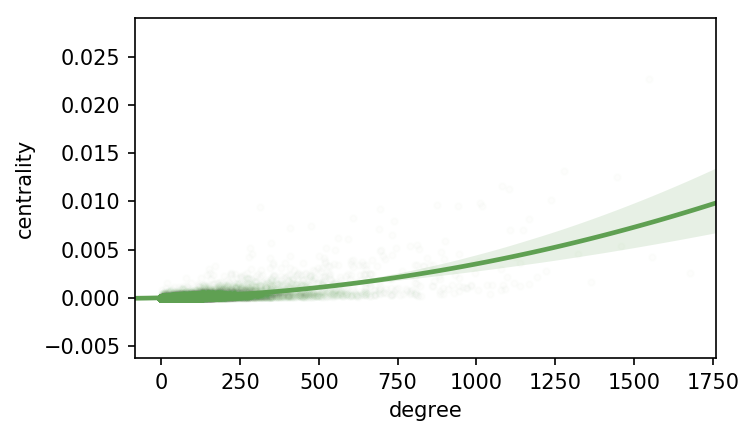

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=150)

sns.regplot('degree', 'centrality', data=df_members, color='xkcd:muted green',
            scatter_kws={'s':10, 'alpha': 0.01}, order=2, ax=ax)
# ax.set_xlim([0,1000])
# ax.set_ylim([0.0,0.005])

plt.show()

In [77]:
import pickle
pickle.dump(df_members, open('all_nash_members.pik', "wb" ))

In [195]:
df_members.loc[tomorrows_attendees].sort_values(by='centrality', ascending=False).join(members['name']).iloc[0:10][['name', 'centrality']]

,name,centrality
129122472,Bryan Overbey,0.004157
43237102,Hameed Gifford,0.003501
12307860,Jeremy,0.002100
55029192,Josh E,0.001387
126309962,Aliya Gifford,0.001205
191186119,Kadu,0.000790
232676485,Trev Lawson,0.000718
13812470,Wayne Martin,0.000545
9852711,Weston Hunter,0.000506
40152352,Kate Brady,0.000499


In [194]:
df_members.loc[tomorrows_attendees].sort_values(by='degree', ascending=False).join(members['name']).iloc[0:10][['name', 'degree']]

,name,degree
55029192,Josh E,1166.0
12307860,Jeremy,1098.0
126309962,Aliya Gifford,945.0
202882025,Michael mead,804.0
9852711,Weston Hunter,792.0
205937561,Carleton Coggins,634.0
43237102,Hameed Gifford,602.0
32214442,Jim Fuqua,546.0
129122472,Bryan Overbey,518.0
191426144,Chip Carnes,518.0


In [193]:
df_members.loc[tomorrows_attendees].sort_values(by='num_events', ascending=False).join(members['name']).iloc[0:10].name

12307860               Jeremy
55029192               Josh E
126309962       Aliya Gifford
191186119                Kadu
43237102       Hameed Gifford
121334792           Greg Back
202882025        Michael mead
9852711         Weston Hunter
129122472       Bryan Overbey
205937561    Carleton Coggins
Name: name, dtype: object

In [185]:
def get_event_attendance(member_id, num_events=5):
    events = pd.Series([v['group_urlname'] for k,v in dict(g[member_id]).items()])
    attendance = events.value_counts()
    
    if not 'PyNash' in attendance.index:
        pynash_visits = 0
    else: 
        pynash_visits = attendance['PyNash']
    
    print('{} ({}) has attended {} events total in {} different groups.\nThey have attended PyNash {} time(s).'.format(members.loc[member_id, 'name'], 
                                                        member_id, attendance.sum(), attendance.shape[0], pynash_visits))
    print('Top attendance:')
    if attendance.shape[0] < 5:
        max_groups = attendance.shape[0]
    else:
        max_groups = num_events
        
    for gp, val in attendance.iloc[0:max_groups].iteritems():
        print('- {}: {}'.format(gp, val))

In [202]:
df_members.loc[tomorrows_attendees].sort_values(by='centrality', ascending=False)

,in_pynash,num_events,degree,clustering,centrality
129122472,True,27.0,518.0,0.159317,4.156890e-03
43237102,True,29.0,602.0,0.199723,3.501133e-03
12307860,False,70.0,1098.0,0.143458,2.100247e-03
55029192,True,55.0,1166.0,0.131983,1.386936e-03
126309962,True,53.0,945.0,0.132347,1.204606e-03
191186119,True,41.0,293.0,0.183880,7.896455e-04
232676485,True,15.0,343.0,0.235913,7.181579e-04
13812470,True,19.0,506.0,0.227934,5.454441e-04
9852711,True,27.0,792.0,0.208897,5.060439e-04
40152352,True,21.0,454.0,0.210394,4.994064e-04


In [ ]:
f = get_event_attendance(55029192, num_events=6)

In [211]:
f = nx.community.k_clique_communities(ge, k=1000)
[len(x) for x in list(f)]

KeyboardInterrupt: 

In [146]:
tomorrows_attendees = [225859679, 208425479, 126309962, 230516487, 53439252, 12140530, 136399942, 9005384, 129122472, 205937561, 191426144, 202007466, 182525541, 121334792, 43237102, 228198627, 12307860, 11943876, 32214442, 55029192, 191186119, 40152352, 227267206, 202882025, 238187518, 239680203, 223421595, 198332016, 34871092, 237392244, 218287357, 189887587, 125196282, 232676485, 218245402, 13812470, 9852711]

In [139]:
df_members = pickle.load( open( "./all_nash_members.pik", "rb" ) )

NameError: name 'pickle' is not defined

In [108]:
df_events = pd.DataFrame(index=tge.nodes)
df_events['num_attendees'] = pd.Series(dict(nx.degree(g, event_nodes)))
df_events['degree'] = pd.Series(dict(nx.degree(tge)))
df_events['clustering'] = pd.Series(nx.clustering(tge))
# df_events['centrality'] = pd.Series(nx.betweenness_centrality(ge, k=3000, 
#                                                                normalized=True, 
#                                                                weight='weight'))


In [116]:
gdf = df_events.join(events).groupby('group_urlname').agg({'name': len, 
                                                     'num_attendees': [np.median],
                                                     'degree': [np.median], 
                                                     'clustering': [np.median]})
gdf.columns=[x[0] for x in gdf.columns]
# gdf.rename(columns={'name_len': 'num_events', 'num_attendees_median': 'median_size', 
#                     'degree_median': 'degree', 'clustering_median': 'clusetering'})
gdf = gdf.loc[(gdf['name'] > 10) & (gdf['num_attendees'] > 5)]

print('\n'.join(gdf.loc[gdf.name>10].sort_values(by='clustering', ascending=True).iloc[0:10].index.tolist()))

MusicCityDrinkingBuddies
Movie-Lovers-Classic-New-and-Foreign-Films
Nashville-Psychotherapy-Institute
SavvyCoders
Tennessee-Real-Estate-Investors-Meetup
meetup-group-FtpRCHbj
NashvilleMusician
funhappeningssocialgroup
paddleadventuresunlimited
nashjs


In [118]:
print('\n'.join(gdf.sort_values(by='degree', ascending=False).iloc[0:10].index.tolist()))

nashjs
MTN-40
Nashville-NET-User-Group
Sunday-Assembly-Nashville
dnd-49
nashville-ux
Data-Science-Nashville
NashvilleFlagFootball
steppingoutsocialdance
NashReact-Meetup


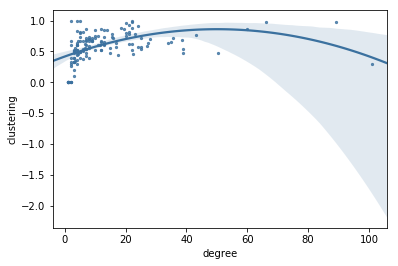

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot('degree', 'clustering', order=2, 
            color='xkcd:muted blue', scatter_kws={'s':5},
            data=gdf)

plt.show()

In [135]:
edge_list = [(u,v) for u,v in ge.edges if ge[u][v]['weight'] > 3]
tge = nx.from_edgelist(edge_list)

In [ ]:
import pickle
pickle.dump(df_events, open('all_nash_events.pik', "wb" ))

In [127]:
nx.is_connected(tge)

False

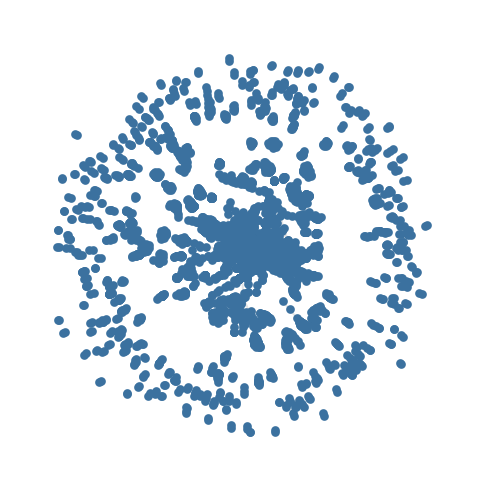

In [138]:
from utils import setup_graph_plot

fig, ax = setup_graph_plot(dpi=150)

pos = nx.spring_layout(tge)
nx.draw_networkx_nodes(tge, pos, nodelist=[n for n in pos.keys()], with_labels=False, node_color='xkcd:muted blue', node_size=10)
nx.draw_networkx_edges(tge, pos, 
                       edgelist=[(u,v) for u,v in tge.edges if (u in pos.keys()) 
                                 & (v in pos.keys())], 
                       alpha=0.1)
plt.show()